# **Dependincies**

In [1]:
%%capture
!pip install lightgbm==3.3.2
!pip install catboost==1.2.2
!pip install xgboost==2.0.3
!pip install optuna
!pip install timm
!pip install pyspellchecker
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0.tar.gz

In [2]:
import pandas as pd
import numpy as np
from time import time
import re
import gc
import shutil
import os
import math
import random
import importlib
import warnings
import pickle
import joblib
from tqdm import tqdm
import sys
sys.path.append('utils')
from pathlib import Path
import string

from scipy.stats import skew, kurtosis
from collections import Counter,defaultdict
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost as cat, gc
import xgboost

print(lgb.__version__)
print(cat.__version__)
print(xgboost.__version__)

from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBClassifier

import optuna

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.nn.functional as F

from transformers import AutoModel,AutoTokenizer
from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# import albumentations as A
# print(A.__version__)
# from albumentations.pytorch import ToTensorV2


3.3.2
1.2.2
2.0.3


2024-11-24 03:43:25.710029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 03:43:25.710133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 03:43:26.060621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 03:43:26.903336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 03:43:28.710971: W tensorflow/compiler/tf2

In [3]:
class clr:
    BLACK     = '\033[30m'
    RED       = '\033[31m'
    GREEN     = '\033[32m'
    YELLOW    = '\033[33m'
    BLUE      = '\033[34m'
    PURPLE    = '\033[35m'
    CYAN      = '\033[36m'
    WHITE     = '\033[37m'
    END       = '\033[0m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    INVISIBLE = '\033[08m'
    REVERCE   = '\033[07m'
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'

my_colors = ["#761D80", "#9926A6", "#9C69C9",
             "#6C91BF", "#58BCC6", "#4AD1B2",
             "#4BF1B2"]

CMAP1 = ListedColormap(my_colors)

In [4]:
def red(x):
    return clr.RED+f'{x}'+clr.END

# **CONFIG**

In [5]:
train_path = 'data/train.csv'
train_con_path = 'data/concepts.csv'

test_path = 'data/test.csv'
sub_path = 'data/sample_submission.csv'

In [6]:
train = pd.read_csv(train_path)
concept = pd.read_csv(train_con_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(sub_path)

In [7]:
TARGETS = train.columns[-4:].tolist()
TARGETS

['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1', 'utility_agent1']

In [8]:
concept.head()

,Id,Name,Description,TypeId,DataTypeId,ComputationTypeId,TaxonomyString,LeafNode,ShowOnWebsite
0,1,Properties,General properties of the game.,1,1,1,1,0,0
1,2,Format,Format of the game.,1,1,1,1.1,0,0
2,3,Time,Time model.,1,1,1,1.1.1,0,0
3,4,Discrete,Players move at discrete intervals.,1,1,1,1.1.1.1,1,1
4,5,Realtime,Moves not discrete.,1,1,1,1.1.1.2,1,1



* 残りの大部分の列は、この行でプレイされたゲームとルールセットの特性を説明します。<br>これらは、抽象的な特徴（そのゲームが確定的か確率的か？）から、具体的な特徴（ゲームが星形のボードを使用しているか？）までさまざまです。また、ルールがどのように記述されているかに関する特徴（例えば、ルールの中に「大なり比較」を含むものがあるか？）から、実際のゲームの挙動に関する特徴（例えば、完全にランダムなプレイアウトを初期状態から終了まで実行できる回数）まで多岐にわたります。詳細はLudiiウェブサイトの概念ページ、またはその関連出版物やconcepts.csvを参照してください。
* num_[wins/draws/losses]_agent1 - （整数）このゲームとこの特定のエージェント2人の対戦において、1番目のエージェントが[勝った/引き分けた/負けた]回数です。
* utility_agent1 - **（浮動小数点数）ターゲット列です。**<br>1番目のエージェントがこのゲームで受け取った報酬値で、シミュレーション全体の結果が集約されています。この値は-1（1番目のエージェントがすべてのゲームに負けた場合）から1（すべてのゲームに勝った場合）の間で変動します。ユーティリティは、(n_games_won - n_games_lost) / n_games という式で計算されます。

In [9]:
# 0しかないcolmuns
ignore_constant_col =  ['Properties', 'Format', 'Time', 'Discrete', 
                        'Realtime', 'Turns', 'Alternating', 'Simultaneous', 
                        'HiddenInformation', 'Match', 'AsymmetricRules', 'AsymmetricPlayRules', 
                        'AsymmetricEndRules', 'AsymmetricSetup', 'Players', 'NumPlayers', 'Simulation', 
                        'Solitaire', 'TwoPlayer', 'Multiplayer', 'Coalition', 'Puzzle', 'DeductionPuzzle', 
                        'PlanningPuzzle', 'Equipment', 'Container', 'Board', 'PrismShape', 
                        'ParallelogramShape', 'RectanglePyramidalShape', 'TargetShape', 'BrickTiling', 
                        'CelticTiling', 'QuadHexTiling', 'Hints', 'PlayableSites', 'Component', 'DiceD3',
                        'BiasedDice', 'Card', 'Domino', 'Rules', 'SituationalTurnKo', 'SituationalSuperko', 
                        'InitialAmount', 'InitialPot', 'Play', 'BetDecision', 'BetDecisionFrequency', 
                        'VoteDecisionFrequency', 'ChooseTrumpSuitDecision', 'ChooseTrumpSuitDecisionFrequency',
                        'LeapDecisionToFriend', 'LeapDecisionToFriendFrequency', 'HopDecisionEnemyToFriend', 
                        'HopDecisionEnemyToFriendFrequency', 'HopDecisionFriendToFriend', 'FromToDecisionWithinBoard', 'FromToDecisionBetweenContainers',
                        'BetEffect', 'BetEffectFrequency', 'VoteEffectFrequency', 'SwapPlayersEffectFrequency', 'TakeControl', 
                        'TakeControlFrequency', 'PassEffectFrequency', 'SetCost', 'SetCostFrequency', 'SetPhase', 
                        'SetPhaseFrequency', 'SetTrumpSuit', 'SetTrumpSuitFrequency', 'StepEffectFrequency', 'SlideEffectFrequency', 
                        'LeapEffectFrequency', 'HopEffectFrequency', 'FromToEffectFrequency', 'SwapPiecesEffect', 
                        'SwapPiecesEffectFrequency', 'ShootEffect', 'ShootEffectFrequency', 'MaxCapture', 'OffDiagonalDirection', 
                        'Information', 'HidePieceType', 'HidePieceOwner', 'HidePieceCount', 'HidePieceRotation', 'HidePieceValue', 
                        'HidePieceState', 'InvisiblePiece', 'End', 'LineDrawFrequency', 'ConnectionDraw', 'ConnectionDrawFrequency', 
                        'GroupLossFrequency', 'GroupDrawFrequency', 'LoopLossFrequency', 'LoopDraw', 'LoopDrawFrequency', 
                        'PatternLoss', 'PatternLossFrequency', 'PatternDraw', 'PatternDrawFrequency', 'PathExtentEndFrequency', 
                        'PathExtentWinFrequency', 'PathExtentLossFrequency', 'PathExtentDraw', 'PathExtentDrawFrequency', 
                        'TerritoryLoss', 'TerritoryLossFrequency', 'TerritoryDraw', 'TerritoryDrawFrequency', 'CheckmateLoss',
                        'CheckmateLossFrequency', 'CheckmateDraw', 'CheckmateDrawFrequency', 'NoTargetPieceLoss', 
                        'NoTargetPieceLossFrequency', 'NoTargetPieceDraw', 'NoTargetPieceDrawFrequency', 'NoOwnPiecesDraw', 
                        'NoOwnPiecesDrawFrequency', 'FillLoss', 'FillLossFrequency', 'FillDraw', 'FillDrawFrequency', 
                        'ScoringDrawFrequency', 'NoProgressWin', 'NoProgressWinFrequency', 'NoProgressLoss', 
                        'NoProgressLossFrequency', 'SolvedEnd', 'PositionalRepetition', 'SituationalRepetition', 'Narrowness', 
                        'Variance', 'DecisivenessMoves', 'DecisivenessThreshold', 'LeadChange', 'Stability', 'DramaAverage', 
                        'DramaMedian', 'DramaMaximum', 'DramaMinimum', 'DramaVariance', 'DramaChangeAverage', 'DramaChangeSign', 
                        'DramaChangeLineBestFit', 'DramaChangeNumTimes', 'DramaMaxIncrease', 'DramaMaxDecrease', 
                        'MoveEvaluationAverage', 'MoveEvaluationMedian', 'MoveEvaluationMaximum', 'MoveEvaluationMinimum', 
                        'MoveEvaluationVariance', 'MoveEvaluationChangeAverage', 'MoveEvaluationChangeSign', 
                        'MoveEvaluationChangeLineBestFit', 'MoveEvaluationChangeNumTimes', 'MoveEvaluationMaxIncrease', 
                        'MoveEvaluationMaxDecrease', 'StateEvaluationDifferenceAverage', 'StateEvaluationDifferenceMedian', 
                        'StateEvaluationDifferenceMaximum', 'StateEvaluationDifferenceMinimum', 'StateEvaluationDifferenceVariance', 
                        'StateEvaluationDifferenceChangeAverage', 'StateEvaluationDifferenceChangeSign', 
                        'StateEvaluationDifferenceChangeLineBestFit', 'StateEvaluationDifferenceChangeNumTimes', 
                        'StateEvaluationDifferenceMaxIncrease', 'StateEvaluationDifferenceMaxDecrease', 'BoardSitesOccupiedMinimum',
                        'BranchingFactorMinimum', 'DecisionFactorMinimum', 'MoveDistanceMinimum', 'PieceNumberMinimum', 
                        'ScoreDifferenceMinimum', 'ScoreDifferenceChangeNumTimes', 'Roots', 'Cosine', 'Sine', 'Tangent', 
                        'Exponential', 'Logarithm', 'ExclusiveDisjunction', 'Float', 'HandComponent', 'SetHidden', 'SetInvisible', 
                        'SetHiddenCount', 'SetHiddenRotation', 'SetHiddenState', 'SetHiddenValue', 'SetHiddenWhat', 'SetHiddenWho']


In [10]:
ignore_null_col = ['Behaviour', 'StateRepetition', 'Duration', 'Complexity', 'BoardCoverage', 
                   'GameOutcome', 'StateEvaluation', 'Clarity', 'Decisiveness', 'Drama', 'MoveEvaluation', 
                   'StateEvaluationDifference', 'BoardSitesOccupied','BranchingFactor', 
                   'DecisionFactor', 'MoveDistance', 'PieceNumber', 'ScoreDifference']

In [11]:
# pairs_col = ['AsymmetricForces', 'AsymmetricPiecesType', 'BackwardRightDirection', 
#              'CircleTiling', 'ForwardRightDirection', 'LeftwardDirection', 'LeftwardsDirection', 
#              'LoopEnd', 'LoopLoss', 'LoopWinFrequency', 'MancalaStyle', 'NoProgressDrawFrequency', 
#              'NumPerimeterSites', 'PathExtent', 'PathExtentEnd', 'PathExtentLoss', 'PathExtentWin', 
#              'PatternWin', 'PatternWinFrequency', 'PieceDirection', 'Roll', 'SetRotation',
#              'SetRotationFrequency', 'ShibumiStyle', 'Sow', 'SowOriginFirst', 'SpiralTiling', 
#              'StackState', 'SwapOption', 'Team', 'TerritoryEnd', 'TerritoryWin', 'TerritoryWinFrequency']

In [12]:
# print(train.shape)
# train.drop(['Id']+ignore_null_col+ignore_constant_col, axis=1, inplace=True)
# train.shape

In [13]:
train.head(2)

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333


In [14]:
#######
# Categorycal dataは、['GameRulesetName', 'agent1', 'agent2', 'EnglishRules', 'LudRules']の5つ
#######
category_col = train.select_dtypes(include=['object', 'category']).columns.to_list()
num_col = train.select_dtypes(include=['number']).columns.to_list()

display(category_col)
print(f'category_col: {red(len(category_col))}')
print(f'numeric_col: {red(len(num_col))}')

['GameRulesetName', 'agent1', 'agent2', 'EnglishRules', 'LudRules']

category_col: 5
numeric_col: 809


# **TARGET**

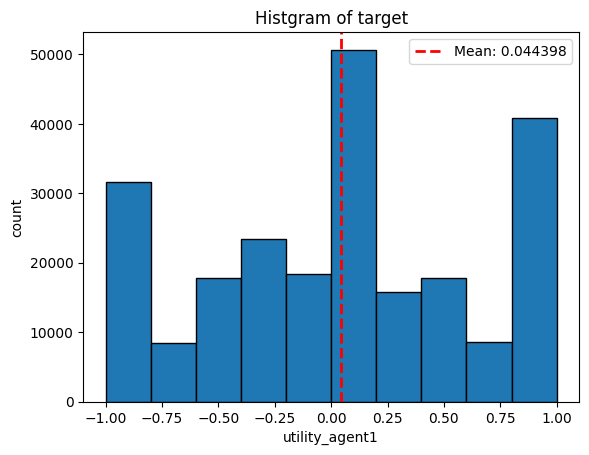

In [15]:
TARGET = 'utility_agent1'
tmp = train[TARGET]
plt.hist(tmp, edgecolor='black')
plt.title('Histgram of target')
plt.xlabel('utility_agent1')
plt.ylabel('count')

mean_value = tmp.mean()
plt.axvline(mean_value, 
            color='red', 
            linestyle='dashed',
            linewidth=2, 
            label=f'Mean: {mean_value:.6f}')
plt.legend()
plt.show()

# **CATEGORYCAL DATA**

In [16]:
####
# categorycal dataの分析
####
category_data = train[category_col]
display(category_data.head(3))

,GameRulesetName,agent1,agent2,EnglishRules,LudRules
0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ..."
1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ..."
2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ..."


## **GameRulesetName**

In [17]:
####
# GameRulesetName - （文字列）Ludiiにおけるゲーム名とルールセット名の組み合わせです。
# Ludiiシステム内では、ゲーム（文化的遺産）とルールセット（同じゲームでも異なるルールセットでプレイされることがある）を区別しています。
# このコンペティションでは、ゲームとルールセットのユニークな組み合わせを別々のゲームとして考えるべきです。
# ただし、いくつかのゲームは（多くの異なるルールセットを持つもの）トレーニングデータで過度に表現されている可能性があります。 
# 種類の数は、1377
# Discussionを見ていると、GameRulesetNameのGroupkholdしている。
# 中には、似たり寄ったりのGameNameが存在する。'58_HolesCarnarvon_and_Carter_D6_Suggested',　'58_HolesCarnarvon_and_Carter_Suggested',みたいな形で。
# Test setにはtrain setには含まれていないGameNameが存在する
####


print(category_data['GameRulesetName'].nunique())
display(category_data['GameRulesetName'].unique().tolist())

1377


['00Y',
 '1D_Chess',
 '20_SquaresSeleucid_Scholarly',
 '3D_Tic-Tac-Toe',
 '4_Squared',
 '58_HolesCarnarvon_and_Carter_D6_Suggested',
 '58_HolesCarnarvon_and_Carter_Suggested',
 '58_HolesCarter_Crossover_1_D4_Suggested',
 '58_HolesCarter_Crossover_1_D6_Suggested',
 '58_HolesCarter_Crossover_1_Suggested',
 '58_HolesCarter_Crossover_2_D4_Suggested',
 '58_HolesCarter_Crossover_2_D6_Suggested',
 '58_HolesCarter_Crossover_2_Suggested',
 '58_HolesCarter_Crossover_3_D4_Suggested',
 '58_HolesCarter_Crossover_3_D6_Suggested',
 '58_HolesCarter_Crossover_3_Suggested',
 '58_HolesCarter_Crossover_4_D4_Suggested',
 '58_HolesCarter_Crossover_4_D6_Suggested',
 '58_HolesCarter_Crossover_4_Suggested',
 '58_HolesCarter_Crossover_5_D4_Suggested',
 '58_HolesCarter_Crossover_5_D6_Suggested',
 '58_HolesCarter_Crossover_5_Suggested',
 '58_HolesCarter_Marked_Holes_D4_Suggested',
 '58_HolesCarter_Marked_Holes_D6_Suggested',
 '58_HolesCarter_Marked_Holes_Suggested',
 '58_HolesCarter_Unmarked_D4_Suggested',
 '58_H

In [18]:
train['GameRulesetName'].value_counts(sort=True)

GameRulesetName
Pathway                                          222
Double_Chess                                     214
Greater_Even_Loss                                212
Resolve                                          212
Ludus_Latrunculorum8x8_Seega_Rules_Suggested     210
                                                ... 
Bheri_Bakhri                                      72
58_HolesTab_Parallel_Connections_D6_Suggested     72
CeelkoqyuqkoqijiFourteen_holes_Observed           72
58_HolesTab_Unmarked_Suggested                    70
Faraday                                            4
Name: count, Length: 1377, dtype: int64

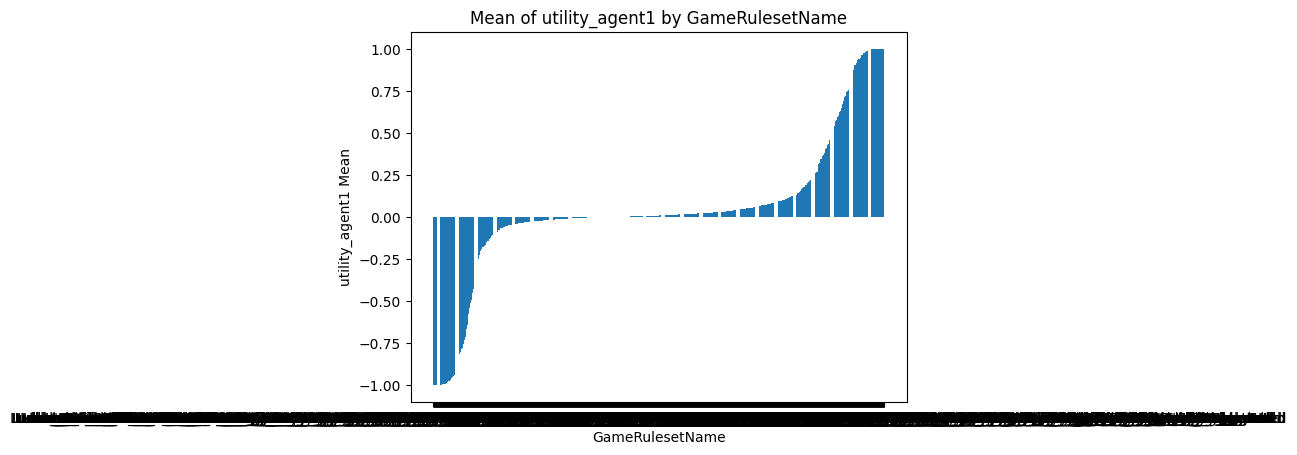

In [19]:
tmp = train.groupby('GameRulesetName')[TARGET].mean().sort_values()
plt.figure()
plt.bar(x=tmp.index, height=tmp.values)

plt.xlabel('GameRulesetName')
plt.ylabel(f'{TARGET} Mean')
plt.title(f'Mean of {TARGET} by GameRulesetName')
plt.show()

In [20]:
####
# targetが-1.0のGameName
# 合計22個ある。
# Ludus_CoriovalliHaretavl_Switch、Ludus_CoriovalliHaretavl_Four_Dogs_Two_Hares_Switch_Starting_が多い
####
display(tmp[tmp==-1.0].index.tolist())
print(red(len(tmp[tmp==-1.0].index.tolist())))

['Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_Top_Extension_No_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_1_-_No_Extension_No_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_Top_Extension_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_No_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_Both_Extensions_Joined_Diagonal_Suggested',
 'Sat_Gol',
 'Ludus_CoriovalliHaretavl_Switch_Players_-_Top_Extension_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Players_-_No_Extension_No_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Switch_Players_-_No_Extension_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Swi

22


In [21]:
###
# targetが1.0のGameName
# 合計30個ある。
# -1と似たり寄ったりのGameNameもある。
###
display(tmp[tmp==1.0].index.tolist())
print(red(len(tmp[tmp==1.0].index.tolist())))

['Janes_SoppiJanes_Soppi_Described',
 'Janes_SoppiHare_wins_Suggested',
 'Snort',
 'Ludus_CoriovalliHaretavl_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested',
 'Yeung_Luk_Sz_Kon_Tseung_KwanMurray_Suggested',
 'Bison',
 'Ludus_CoriovalliHaretavl_Starting_Position_-_Top_Extension_No_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Starting_Position_-_Top_Extension_Joined_Diagonal_Suggested',
 'Go_with_the_Floe',
 'Ludus_CoriovalliHaretavl_Starting_Position_-_Both_Extensions_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_-_Top_Extension_Joined_Diagonal_Suggested',
 'Choro_Lango',
 'Ludus_CoriovalliHaretavl_Four_Dogs_Two_Hares_Starting_Position_2_-_No_Extension_Joined_Diagonal_Suggested',
 'Contagion',
 'Ludus_CoriovalliHaretavl_Four_Dogs_Two_Hares_Starting_Position_2_-_Both_Extensions_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Four_Dogs_Two_Hares_Starting_Position_1_-_Top_Extension_Joined_Diagonal_Suggested',
 'Ludus_CoriovalliHaretavl_Four_Dogs_Two_Ha

30


In [22]:
####
# GameRulesNameでGroupbyし、stdを計算した。
# その場合、Targetとなる列以外の列は、stdが0となった。
# つまり、同じGameRulesNameの場合、特徴量となる列は全て同じ数値であることを意味する。
####
tmp = train.groupby('GameRulesetName')[num_col].agg('std')
std_rows_withoout_zero = tmp.loc[:, (tmp != 0).any(axis=0)]
std_rows_withoout_zero

,Id,Behaviour,StateRepetition,Duration,Complexity,BoardCoverage,GameOutcome,StateEvaluation,Clarity,Decisiveness,...,BoardSitesOccupied,BranchingFactor,DecisionFactor,MoveDistance,PieceNumber,ScoreDifference,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
GameRulesetName,,,,,,,,,,,,,,,,,,,,,
00Y,57.301832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.149945,0.000000,2.149945,0.286659
1D_Chess,44.600075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.045014,5.009697,0.470729,0.329099
20_SquaresSeleucid_Scholarly,23.237900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.021442,0.000000,3.015152,0.301882
3D_Tic-Tac-Toe,50.950957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.722169,0.000000,2.921039,0.388671
4_Squared,48.641546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.724180,0.651269,2.781538,0.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zamma,57.879185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.209809,1.001255,5.177105,0.673043
Zola,54.992424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.137630,0.000000,3.137630,0.418351
Zurgaan_Tal,50.373604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.580875,0.689264,4.559953,0.584706


## Agent

In [23]:
'''
要はAgentがどのようなアルゴリズムかを示す。
特定のアルゴリズムが強いかどうか見てみてもいいか？

トレーニングデータとテストデータにあるすべてのエージェント文字列の説明は、以下の形式になっています:
MCTS-<SELECTION>-<EXPLORATION_CONST>-<PLAYOUT>-<SCORE_BOUNDS>
それぞれの要素は次のように定義されています：
    
<SELECTION>: UCB1, UCB1GRAVE, ProgressiveHistory, UCB1Tuned のいずれかです。
これらは、MCTSアルゴリズムの選択フェーズで使用される異なる戦略です。

<EXPLORATION_CONST>: 0.1, 0.6, 1.41421356237 のいずれかです。
これらは、テストした「探索定数」の3つの異なる値であり、すべての選択戦略で共通の数値ハイパーパラメータです。

<PLAYOUT>: Random200, MAST, NST のいずれかです。これらは、MCTSアルゴリズムのプレイアウトフェーズで使用される異なる戦略です。

<SCORE_BOUNDS>: true または false で、

MCTSの「スコアバウンディング」バージョン（アルゴリズムが探索ツリーの特定のノードを勝利/敗北/引き分けと証明し、それに応じて探索を調整できるバージョン）が使用されているかどうかを示します。
'''

'\n要はAgentがどのようなアルゴリズムかを示す。\n特定のアルゴリズムが強いかどうか見てみてもいいか？\n\nトレーニングデータとテストデータにあるすべてのエージェント文字列の説明は、以下の形式になっています:\nMCTS-<SELECTION>-<EXPLORATION_CONST>-<PLAYOUT>-<SCORE_BOUNDS>\nそれぞれの要素は次のように定義されています：\n    \n<SELECTION>: UCB1, UCB1GRAVE, ProgressiveHistory, UCB1Tuned のいずれかです。\nこれらは、MCTSアルゴリズムの選択フェーズで使用される異なる戦略です。\n\n<EXPLORATION_CONST>: 0.1, 0.6, 1.41421356237 のいずれかです。\nこれらは、テストした「探索定数」の3つの異なる値であり、すべての選択戦略で共通の数値ハイパーパラメータです。\n\n<PLAYOUT>: Random200, MAST, NST のいずれかです。これらは、MCTSアルゴリズムのプレイアウトフェーズで使用される異なる戦略です。\n\n<SCORE_BOUNDS>: true または false で、\n\nMCTSの「スコアバウンディング」バージョン（アルゴリズムが探索ツリーの特定のノードを勝利/敗北/引き分けと証明し、それに応じて探索を調整できるバージョン）が使用されているかどうかを示します。\n'

In [24]:
####
# agent[1/2] - （文字列）[1/2]番目のプレイヤーとしてプレイしたエージェントの説明です。
# エージェント文字列の詳細については、下記のエージェント文字列説明セクションを参照してください。
# agent1
# 種類の数は、72
####
print(category_data['agent1'].nunique())
agent1 = category_data['agent1'].unique().tolist() 
# display(agent1)

####
# agent2
# 種類の数は、72 (agent1と同じ数)
# agent1とagent2の種類は同じ。
####
print(category_data['agent2'].nunique())
agent2 = category_data['agent2'].unique().tolist() 
# display(agent2)

only_in_agent1 = set(agent1) - set(agent2)
only_in_agent2 = set(agent2) - set(agent1)
print(only_in_agent2)

72
72
set()


In [25]:
# 正規表現パターン
pattern = r'MCTS-(.*)-(.*)-(.*)-(.*)'

# agent1に対する抽出
train['p1_selection'] = train['agent1'].str.extract(pattern, expand=True)[0]
train['p1_exploration'] = train['agent1'].str.extract(pattern, expand=True)[1].astype('float32')
train['p1_playout'] = train['agent1'].str.extract(pattern, expand=True)[2]
train['p1_bounds'] = train['agent1'].str.extract(pattern, expand=True)[3]

# agent2に対する抽出
train['p2_selection'] = train['agent2'].str.extract(pattern, expand=True)[0]
train['p2_exploration'] = train['agent2'].str.extract(pattern, expand=True)[1].astype('float32')
train['p2_playout'] = train['agent2'].str.extract(pattern, expand=True)[2]
train['p2_bounds'] = train['agent2'].str.extract(pattern, expand=True)[3]

player_features = ['p1_selection', 'p1_exploration', 'p1_playout', 'p1_bounds',
                   'p2_selection', 'p2_exploration', 'p2_playout', 'p2_bounds']

In [26]:
train['p2_selection'].unique()

array(['ProgressiveHistory', 'UCB1GRAVE', 'UCB1', 'UCB1Tuned'],
      dtype=object)

In [27]:
tmp = train.copy()

In [28]:
cols = ['p1_selection',
         'p1_exploration',
         'p1_playout',
         'p1_bounds',
         'p2_selection',
         'p2_exploration',
         'p2_playout',
         'p2_bounds']

In [29]:
from itertools import combinations
# 異なるカラムペアの組み合わせを生成し、それぞれに対して文字列を結合
for col1, col2 in combinations(cols, 2):
    tmp[f'{col1}_{col2}'] = tmp[col1].astype(str) + "-" + tmp[col2].astype(str)

In [30]:
for col1, col2, col3 in combinations(cols, 3):
    tmp[f'{col1}_{col2}_{col3}'] = tmp[col1].astype(str) + "-" + tmp[col2].astype(str) + "-" + tmp[col3].astype(str)

## EnglishRules

In [31]:
####
# EnglishRules - （文字列）ゲームのルールを自然言語（英語）で記述したものです。
# この記述は自己完結していることは保証されておらず（例えば、チェスなどの有名な他のゲームのルールに言及することがあるため）、
# あいまいだったり、完全でなかったりする場合があります。
# 種類の数は、1328
# GameRulesetNameと同じ数かと思ったが、異なる。つまり、同じEnglishRuleのものでも、GameNameは異なるものがある？
####
print(category_data['EnglishRules'].nunique())

1328


In [32]:
game_name='CeelkoqyuqkoqijiEagle_Observed'
train[train['GameRulesetName']==game_name]['EnglishRules'].unique()

array(["2x5 board with one store on either end. The store to the right of the player belongs to the player. Play begins with five counters in each regular hole, with one larger stone in each store, but one is slightly smaller than the other. Game can be played with two or four players. With four players, two players control the larger stones, but cannot move the regular counters. Players throw out a finger (index, little, or thumb) to determine who plays first. Index beats thumb, thumb beats little finger, little finger beats index. This happens at the start of each round. Counters are taken from any of the holes in the player's row, sowing them in either direction, including the stores. When the last counter of a sowing is dropped in a hole, sowing continues by picking up the counters in the next hole and continuing to sow in that direction. If the hole following the last seed of a sowing is empty, the counters in the hole following this empty hole are captured. If there is an empty h

In [33]:
train.shape

(233234, 822)

In [34]:
sys.path.append('UM_utilities')
import utils as my_utils
importlib.reload(my_utils)


<module 'utils' from '/notebooks/UM_utilities/utils.py'>

## LudRules

In [45]:
####
# LudRules - （文字列）Ludiiのゲーム記述言語で記述されたゲームの説明です。
# この記述は、Ludii内部でゲームをコンパイルしシミュレーションを実行するために使用されたものなので、常に100%完全かつ明確です。
# ただし、これは形式言語であり、既存の大規模言語モデルやファウンデーションモデルがこれまでにほとんど、もしくは全く触れていない可能性が高いです。
# 種類の数は、1373. GameRulesetNameの数は1377なので、異なるGameRulesetNameで同じLudRulesとなっているものが存在する。
# GameRulesetNameと同じ数かと思ったが、これも異なる。English Rulesの数とも異なる。
####

print(category_data['LudRules'].nunique())

1373


In [46]:
####
# GameRulesetNameの数は1377なので、異なるGameRulesetNameで同じLudRulesとなっているものが存在する。
# その該当するGameNameは下記の通り、下記セットのGameNameは、GameNameが異なるのに、同一のLudRulesとなっている。
# Gameの名前は異なるが、ルールは同じなのか？

# ['CeelkoqyuqkoqijiEagle_Observed' 'CeelkoqyuqkoqijiEqual_Cost_Observed']
#　['Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_No_Joined_Diagonal_Suggested'
# 'Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_1_-_No_Extension_No_Joined_Diagonal_Suggested']

#['Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested'
#'Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested']

# ['ShonoChildren_Observed' 'ShonoShono_Observed']
####

ludrules_count_per_game = train.groupby('LudRules')['GameRulesetName'].nunique()
ludrules_multiple = ludrules_count_per_game[ludrules_count_per_game != 1]
print(red(ludrules_multiple.values))
for i in ludrules_multiple.index:
    print('')
    print(train[train['LudRules']==i]['GameRulesetName'].unique())

[2 2 2 2]

['CeelkoqyuqkoqijiEagle_Observed' 'CeelkoqyuqkoqijiEqual_Cost_Observed']

['Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_No_Joined_Diagonal_Suggested'
 'Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_1_-_No_Extension_No_Joined_Diagonal_Suggested']

['Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested'
 'Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested']

['ShonoChildren_Observed' 'ShonoShono_Observed']


In [47]:
game_name='Ludus_CoriovalliHaretavl_Switch_Two_Dogs_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested'
train[train['GameRulesetName']==game_name]['LudRules'].unique()[0]

'(game "Ludus Coriovalli" (players 2) (equipment { (board (add (merge { (scale 2 1 (rectangle 1 3)) (rectangle 2 1) (shift 4 0 (rectangle 2 1)) (shift 4 1.5 (rectangle 2 1)) (shift 0 1.5 (rectangle 2 1)) (scale 2 1 (shift 0 2.5 (rectangle 1 3))) } ) edges:{ {3 7} {5 4} {9 1} {3 1} {1 4} {5 9} {9 7} } ) use:Vertex ) (piece "Dog" P2 (move Step (to if:(is Empty (to))))) (piece "Hare" P1 (move Step (to if:(is Empty (to))))) } ) (rules (start { (place "Hare1" (sites {"B1"})) (place "Dog2" (sites {"A4" "B4" "C4"})) } ) (play (forEach Piece)) (end { (if (no Moves P1) (result P2 Win)) (if (or (>= (count Moves) (- (value MoveLimit) 10)) (>= (count Turns) (- (value TurnLimit) 5)) ) (result P1 Win) ) } ) ) )'

In [48]:
game_name='Ludus_CoriovalliHaretavl_Switch_Starting_Position_-_No_Extension_Joined_Diagonal_Suggested'
a = train[train['GameRulesetName']==game_name]['LudRules'].unique()[0]
# displa(a)

In [49]:
game_name='CeelkoqyuqkoqijiEqual_Cost_Observed'
b = train[train['GameRulesetName']==game_name]['LudRules'].unique()[0]

In [50]:
game_name='CeelkoqyuqkoqijiEagle_Observed'
a = train[train['GameRulesetName']==game_name]['LudRules'].unique()[0]

In [51]:
set(a) - set(b)

set()

In [52]:
FE = my_utils.UM_FE()
# data = FE.fe1(train.copy())
# data = FE.fe2(data)
# data = FE.fe3(data)
# data = FE.fe4(data)
# data = FE.fe5(data)
# FE = my_utils.UM_FE()
data = FE.fe9(train)
# data = FE.drop_cols(train)

# print(f'train:{red(data.shape)}')

fe9 Done! DATA Shape:(233234, 824)


In [53]:
data['game_equipment'].unique()

array(['board', 'mancalaBoard', 'boardless', 'piece', 'surakartaBoard'],
      dtype=object)

In [54]:
data[data['game_name']=='1D Chess']['LudRules'].unique()[0]

'(game "1D Chess" (players 2) (equipment { (board (rectangle 1 8)) (piece "Rook" Each (move Slide Orthogonal (to if:(is Enemy (who at:(to))) (apply (remove (to)))) ) ) (piece "King" Each (move Step (to if:(not (is Friend (who at:(to)))) (apply (if (is Enemy (who at:(to))) (remove (to)))) ) ) ) (piece "Knight" Each (move Leap { { F F } } (to if:(not (is Friend (who at:(to)))) (apply (if (is Enemy (who at:(to))) (remove (to)))) ) ) ) } ) (rules (start { (place "Rook1" coord:"C1") (place "Knight1" coord:"B1") (place "King1" coord:"A1") (place "Rook2" coord:"F1") (place "Knight2" coord:"G1") (place "King2" coord:"H1") } ) (play (do (forEach Piece) ifAfterwards:(not (is Threatened (id "King" Mover))) ) ) (end { (if (and (is Threatened (id "King" Next)) (not (can Move (do (forEach Piece Next) ifAfterwards:(not (is Threatened (id "King" Next)) ) ) ) ) ) (result Mover Win) ) (if (or (no Moves Mover) (= (counter) 100)) (result Mover Draw) ) } ) ) )'

In [55]:
train['LudRules'].nunique()

1373

In [56]:
data['game_name'].nunique()

1030

In [ ]:
from collections import defaultdict

# クラスタを格納する辞書を初期化
game_clusters = defaultdict(list)
game_names = data['game_name'].unique().tolist()
# 各単語に対して、その単語が他のゲーム名に含まれるかをチェック
for game in game_names:
    added_to_cluster = False
    for key in game_clusters.keys():
        if key in game or game in key:
            game_clusters[key].append(game)
            added_to_cluster = True
            break
    if not added_to_cluster:
        game_clusters[game].append(game)

game_cluster_mapping = {}
for cluster_key, cluster_games in game_clusters.items():
    for game in cluster_games:
        game_cluster_mapping[game] = cluster_key
for cluster_key, cluster_games in game_clusters.items():
    if len(cluster_games) > 1:  # 複数のゲームが含まれるクラスタのみ表示
        print(f"Cluster '{cluster_key}': {cluster_games}")

In [ ]:
df['Cluster'].nunique()

In [ ]:
df['Game Name'].nunique()

In [ ]:
train['GameRulesetName'].nunique()

In [ ]:
def find_common_substring(s1, s2, min_length=4):
    len_s1 = len(s1)
    for i in range(len_s1 - min_length + 1):
        substring = s1[i:i + min_length]
        if substring in s2:
            return True
    return False

for game in game_names:
    added_to_cluster = False
    for key in game_clusters.keys():
        if find_common_substring(key, game):
            game_clusters[key].append(game)
            added_to_cluster = True
            break
    if not added_to_cluster:
        game_clusters[game].append(game)

# クラスタ情報を持つ新しいデータフレームを作成
game_cluster_mapping = {}
for cluster_key, cluster_games in game_clusters.items():
    for game in cluster_games:
        game_cluster_mapping[game] = cluster_key

df = pd.DataFrame(game_names, columns=['Game Name'])
df['Cluster'] = df['Game Name'].map(game_cluster_mapping)

# データフレームを表示
print(df)

# クラスタの結果を表示
for cluster_key, cluster_games in game_clusters.items():
    if len(cluster_games) > 1:  # 複数のゲームが含まれるクラスタのみ表示
        print(f"Cluster '{cluster_key}': {cluster_games}")

In [ ]:
def find_common_substring(s1, s2, min_length=4):
    len_s1 = len(s1)
    for i in range(len_s1 - min_length + 1):
        substring = s1[i:i + min_length]
        if substring in s2:
            return True
    return False

cleaned_game_names = [re.sub(r'\(.*?\)', '', game).strip() for game in game_names]
for game in cleaned_game_names:
    added_to_cluster = False
    for key in game_clusters.keys():
        if find_common_substring(key, game):
            game_clusters[key].append(game)
            added_to_cluster = True
            break
    if not added_to_cluster:
        game_clusters[game].append(game)

# クラスタ情報を持つ新しいデータフレームを作成
game_cluster_mapping = {}
for cluster_key, cluster_games in game_clusters.items():
    for game in cluster_games:
        game_cluster_mapping[game] = cluster_key

df = pd.DataFrame(game_names, columns=['Game Name'])
df['Cleaned Game Name'] = df['Game Name'].apply(lambda x: re.sub(r'\(.*?\)', '', x).strip())
df['Cluster'] = df['Cleaned Game Name'].map(game_cluster_mapping)

# データフレームを表示
print(df)

# クラスタの結果を表示
for cluster_key, cluster_games in game_clusters.items():
    if len(cluster_games) > 1:  # 複数のゲームが含まれるクラスタのみ表示
        print(f"Cluster '{cluster_key}': {cluster_games}")

# **PCA**

In [ ]:
sys.path.append('UM_utilities')
sys.path.append('mlp_config')

import mlp_config as my_config
import utils as my_utils
data=train.copy()

In [ ]:
print(f'INITIAL DATA Shape:{red(data.shape)}')
print('')
FE = my_utils.UM_FE()
data = FE.fe1(data.copy())
data = FE.fe2(data.copy())
data = FE.fe3(data.copy())
# data = FE.fe9(data.copy())
# data = FE.fe4(data.copy())
# data = FE.fe5(data.copy())
# data = FE.fe6(data.copy())
# data = FE.fe7(data.copy())
# data = FE.fe8(data.copy())

# Drop Data
data = FE.drop_cols(data, game_drop=True)

# Trains Obj => Categorical data
data, _ = FE.trans_obj_cate(data)

print('')
print(f'Final DATA Shape:{red(data.shape)}')

## **CONCAT OOF PREDICTIONS**

In [ ]:
USE_OOF = True
EXP_NUM_LIST = ['EXP-37', 'EXP-39', 'EXP-40', 'EXP-43', 'EXP-44', 'EXP-45']

predictions={}
for EXP_NUM in EXP_NUM_LIST:
    SAVE_PATH = f'{my_config.general.model_save_path}/TREE_{EXP_NUM}'
    oof_preds = joblib.load(f'{SAVE_PATH}/oof_preds_{EXP_NUM}.pkl')
    oof_preds = {key: np.clip(value, a_min=-1.0, a_max=1.0) for key, value in oof_preds.items()}
    oof_preds = {model: oof_preds[model].flatten() for model in oof_preds}
    
    cols = [f"{col.split('_')[0]}-{EXP_NUM}" for col in oof_preds]
    oof_preds_df = pd.DataFrame(oof_preds)
    oof_preds_df.columns = cols
    predictions[EXP_NUM]=(oof_preds_df)

true = train['utility_agent1'].copy()
print(len(predictions))

In [ ]:
predictions_df = pd.DataFrame()
for col in predictions:
    tmp_df = predictions[col]
    predictions_df = pd.concat([predictions_df, tmp_df], axis=1)
predictions_df = predictions_df.astype('float64')

if USE_OOF:
    data = pd.concat([data, predictions_df], axis=1)
    # data = FE.fe6(data.copy())
    # exp_num = 'EXP-38'
    # data = FE.drop_cols_fi3(data.copy(), 
    #                       save_path='model', 
    #                       exp_num=f'TREE_{exp_num}', 
    #                       topn=500)

# data.replace([np.inf, -np.inf], np.nan, inplace=True)

## **CHECK DATA**

In [ ]:
#######
# Categorycal dataは、['GameRulesetName', 'agent1', 'agent2', 'EnglishRules', 'LudRules']の5つ
#######
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
num_cols = data.drop(columns=TARGETS).select_dtypes(include=['number']).columns.to_list()

# display(categorical_cols)
print(f'category_col: {red(len(categorical_cols))}')
print(f'numeric_col: {red(len(num_cols))}')

In [ ]:
# NN Modelの場合はIDをvalで使用するのでconcatする。
data = pd.concat([data, train['Id']], axis=1)
data = FE.clip_outliers(data.copy())

# Trainsform Feature
if my_config.general.scaler=='standard':
    data = FE.standard_scaler(data.copy())
elif my_config.general.scaler=='robust':
    data = FE.robust_scaler(data.copy())
elif my_config.general.scaler=='quant':
    data = FE.quant_trans(data.copy())
else:
    data = FE.log_trans(data.copy())

# data = FE.label_encoder(data.copy())
data[num_cols] = data[num_cols].astype(np.float64)
# data.drop(categorical_cols, axis=1, inplace=True)

FEATURES = data.drop(TARGETS, axis=1).columns.tolist()
len(FEATURES)

In [ ]:
data[num_cols]

In [ ]:
from sklearn.decomposition import PCA

n_com = 50
pca = PCA(n_components=n_com)
data_pca = pca.fit_transform(data[num_cols])
print(data_pca)

In [ ]:
data_pca_df = pd.DataFrame(data_pca)
columns = [f'PC{i}' for i in range(0, n_com)]
data_pca_df.columns = columns
data_pca_df = pd.concat([data_pca_df, data[categorical_cols]], axis=1)
data_pca_df = pd.concat([data_pca_df, train[TARGETS]], axis=1)


In [ ]:
data_pca_df.to_csv('pca/pca_150.csv', index=False)
joblib.dump(categorical_cols, 'pca/categorical_cols.joblib')
joblib.dump(pca, 'pca/pca_model.joblib')

In [ ]:
joblib.dump(categorical_cols, 'model/NN_EXP-44/categorical_cols_pca.joblib')
joblib.dump(pca, 'model/NN_EXP-44/pca_model.joblib')
joblib.dump(EXP_NUM_LIST, 'model/NN_EXP-44/pca_oof_list')

In [ ]:
data_pca_df[]

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

# DEBUG

In [ ]:
print(f'INITIAL DATA Shape:{red(data.shape)}')
print('')
FE = my_utils.UM_FE()
data = FE.fe1(data.copy())
data = FE.fe2(data.copy())
data = FE.fe3(data.copy())
# data = FE.fe9(data.copy())
# data = FE.fe4(data.copy())
# data = FE.fe5(data.copy())
# data = FE.fe6(data.copy())
# data = FE.fe7(data.copy())
# data = FE.fe8(data.copy())

# Drop Data
data = FE.drop_cols(data, game_drop=True)

# exp_num = 'EXP-21'
# data = FE.drop_cols_fi3(data.copy(), 
#                       save_path='model', 
#                       exp_num=f'TREE_{exp_num}', 
#                       topn=300)

# Trains Obj => Categorical data
data, _ = FE.trans_obj_cate(data)

print('')
print(f'Final DATA Shape:{red(data.shape)}')

In [ ]:
USE_OOF = True
EXP_NUM_LIST = ['EXP-8', 'EXP-12', 'EXP-14', 'EXP-26']

predictions={}
for EXP_NUM in EXP_NUM_LIST:
    SAVE_PATH = f'{my_config.general.model_save_path}/TREE_{EXP_NUM}'
    oof_preds = joblib.load(f'{SAVE_PATH}/oof_preds_{EXP_NUM}.pkl')
    oof_preds = {key: np.clip(value, a_min=-1.0, a_max=1.0) for key, value in oof_preds.items()}
    oof_preds = {model: oof_preds[model].flatten() for model in oof_preds}
    
    cols = [f"{col.split('_')[0]}-{EXP_NUM}" for col in oof_preds]
    oof_preds_df = pd.DataFrame(oof_preds)
    oof_preds_df.columns = cols
    predictions[EXP_NUM]=(oof_preds_df)

true = train['utility_agent1'].copy()
print(len(predictions))

In [ ]:
predictions_df = pd.DataFrame()
for col in predictions:
    tmp_df = predictions[col]
    predictions_df = pd.concat([predictions_df, tmp_df], axis=1)
predictions_df = predictions_df.astype('float64')

if USE_OOF:
    data = pd.concat([data, predictions_df], axis=1)

In [ ]:
EXP_NUM = 'EXP-19'
SAVE_PATH = f'{my_config.general.model_save_path}/TREE_{EXP_NUM}'


i=0
model = joblib.load(f'{SAVE_PATH}/CAT_{EXP_NUM}_f{i}.pkl')
cat_feature_indices = model.get_cat_feature_indices()
cat_columns = data[FEATURES].columns[cat_feature_indices]

In [ ]:
column_name = 'p1_selection'
column_index = data[FEATURES].columns.get_loc(column_name)
column_index

In [ ]:
cat_feature_indices